In [23]:
import numpy as np
import _pickle as pickle
import gym
import time
import matplotlib.pyplot as plt
import os

# hyperparameters
hidden_layer_neurons = 200
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
game_dimensions = 80 * 80 # input dimensionality: 80x80 grid

In [15]:
#TODO: With sqroot, paddle explores more of the board. Why is that?

try:
    with open("ControlRunningRewards.txt", "rb") as fp:   # Unpickling
        running_rewards = pickle.load(fp)
    resume = True
except:
    running_rewards = []

if resume:
    model = pickle.load(open('save.p', 'rb')) #This allows you to resume training
else:
    model = {}
    model['W1'] = np.random.randn(hidden_layer_neurons, game_dimensions) / np.sqrt(game_dimensions) # "Xavier" initialization. Idea is to set the initial and output variance to be the same so vanishing/exploding gradient doesn't happen
    #Weights live in the connections. Which is why the weights are 200 by 6400 because that is the total number of connections
    model['W2'] = np.random.randn(hidden_layer_neurons) / np.sqrt(hidden_layer_neurons)
    #Stores 200 weights

In [16]:
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def relu(x):
    if x < 0:
        return 0
    return x

def tanh(x):
    return np.tanh(x)

def softmax(x): 
    pass

#TODO: I wonder if we can play around with the downsampling. If you get an error, you need to adjust the game dimensions
#Just see the other number (if you do ::3 then it will be 2916) and take the square root. Then, use replace that
#number with the numbers in the game_dimensions variable

def prepro(input_frame):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    input_frame = input_frame[34:194] # crop
    input_frame = input_frame[::2,::2,0] # downsample by factor of 2 (halves the resolution of the image)
    #This takes every other pixel in the image
    input_frame[input_frame == 144] = 0 # erase background (background type 1)
    input_frame[input_frame == 109] = 0 # erase background (background type 2)
    input_frame[input_frame != 0] = 1 # everything else (paddles, ball) just set to 1
    return input_frame.astype(np.float).ravel()

#TODO: Play around with gamma values

def discount_rewards(rewards):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(rewards)
    running_add = 0
    # print(rewards)  r is a 2d array with the given rewards
    for t in reversed(range(0, rewards.size)):
        if rewards[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + rewards[t]
        discounted_r[t] = running_add
    return discounted_r

# TODO: look into adding bias
def policy_forward(change_in_frame):
    hidden_layer_values = np.dot(model['W1'], change_in_frame)
    hidden_layer_values[hidden_layer_values<0] = 0 # ReLU nonlinearity
    log_probability = np.dot(model['W2'], hidden_layer_values)
    up_prob = sigmoid(log_probability)
    return up_prob, hidden_layer_values # return probability of taking action 2, and hidden state

In [17]:
# TODO: understand and rename (if needed) dh
# dC_dw1: derivative of the cost / derivative of the weights 1 --> partial derivative
# dC_dw2: derivative of the cost / derivative of the weights 2 --> partial derivative
#comb_ep_hidden_layer_values.T and dh.T are the transposed matrices of comb_ep_hidden_layer_values and dh, respectively
def policy_backward(comb_ep_hidden_layer_values, comb_ep_gradient_log_ps):
    """ backward pass. (comb_ep_hidden_layer_values is array of intermediate hidden states) """
    dC_dw2 = np.dot(comb_ep_hidden_layer_values.T, comb_ep_gradient_log_ps).ravel()
    dh = np.outer(comb_ep_gradient_log_ps, model['W2'])
    dh[comb_ep_hidden_layer_values <= 0] = 0 # backpro prelu
    dC_dw1 = np.dot(dh.T, comb_ep_observations) #Why is comb_ep_observations
    return {'W1':dC_dw1, 'W2':dC_dw2}

In [28]:
env = gym.make("Pong-v0")
observation = env.reset() # gets very first image of the game
prev_frame = None # used in computing the difference frame 
ep_hidden_layer_values,ep_gradient_log_ps,ep_rewards,ep_change_in_frames = [],[],[],[]
running_reward = None
reward_sum = 0
temp = 1
episode_number = 0
    
while True:
    if render: 
        env.render()
        #time.sleep(0.1)

    # preprocess the observation, set input to network to be difference image
    curr_frame = prepro(observation)
    change_in_frame = curr_frame - prev_frame if prev_frame is not None else np.zeros(game_dimensions)
    prev_frame = curr_frame
    
    # forward the policy network and sample an action from the returned probability
    up_prob, hidden_layer_values = policy_forward(change_in_frame)
    action = 2 if np.random.uniform() < up_prob else 3 # roll the dice! Generates random probability. This is used for exploring

    #2 means up and 3 means down

    # record various intermediates (needed later for backprop)
    ep_change_in_frames.append(change_in_frame) # observation
    ep_hidden_layer_values.append(hidden_layer_values) # hidden state
    y = 1 if action == 2 else 0 # a "fake label". Our paddle only take the values of 2 and 3 so we need this.
    ep_gradient_log_ps.append(y - up_prob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    #Stores error which is error of the cost

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action) #This is where we tell our paddle to move up or down
    reward_sum += reward

    ep_rewards.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        comb_ep_observations = np.vstack(ep_change_in_frames)
        comb_ep_hidden_layer_values = np.vstack(ep_hidden_layer_values)
        comb_ep_gradient_log_ps = np.vstack(ep_gradient_log_ps)
        comb_ep_rewards = np.vstack(ep_rewards)
        ep_hidden_layer_values,ep_gradient_log_ps,ep_rewards,ep_change_in_frames = [],[],[],[] # reset array memory

        # compute the discounted reward backwards through time
        discounted_comb_ep_rewards = discount_rewards(comb_ep_rewards) # comb_ep_rewards is an array of the rewards
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_comb_ep_rewards -= np.mean(discounted_comb_ep_rewards) # calculates mean and subtracts from each value
        discounted_comb_ep_rewards /= np.std(discounted_comb_ep_rewards)

        comb_ep_gradient_log_ps *= discounted_comb_ep_rewards # modulate the gradient with advantage (PG magic happens right here.)

        grad = policy_backward(comb_ep_hidden_layer_values, comb_ep_gradient_log_ps)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch. Why?

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

        # boring book-keeping

        if len(running_rewards) > 0:
            running_reward = running_rewards[-1]
        
        if len(running_rewards) != 0:
            temp = 100
        
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01 #What is this
        running_rewards.append(running_reward)

        with open("ControlRunningRewards.txt", "wb") as fp:   #Pickling
            pickle.dump(running_rewards, fp)

        print ('resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
        if episode_number % temp == 0: pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_frame = None
        
        if len(running_rewards) == 6001:
            break
        
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print('ep %d: game finished, reward: %f' % (episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))

/var/folders/yg/l9jkh13d6bbgrh7g2fd0b_540000gn/T/ipykernel_14390/1640369312.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return input_frame.astype(np.float).ravel()


ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: 1.000000 !!!!!!!!
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: 1.000000 !!!!!!!!
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.559120
ep 1: game finished, reward: -1.000000
ep 1: game

ep 8: game finished, reward: -1.000000
ep 8: game finished, reward: -1.000000
ep 8: game finished, reward: -1.000000
ep 8: game finished, reward: -1.000000
ep 8: game finished, reward: -1.000000
ep 8: game finished, reward: -1.000000
ep 8: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.544269
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: 1.000000 !!!!!!!!
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: 1.000000 !!!!!!!!
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game finished, reward: -1.000000
ep 9: game

ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
ep 17: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.555828
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 18: game finished, reward: -1.000000
ep 

ep 25: game finished, reward: -1.000000
ep 25: game finished, reward: -1.000000
ep 25: game finished, reward: -1.000000
ep 25: game finished, reward: -1.000000
ep 25: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.560450
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: 1.000000 !!!!!!!!
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.000000
ep 26: game finished, reward: -1.00

ep 33: game finished, reward: -1.000000
ep 33: game finished, reward: -1.000000
ep 33: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -17.000000. running mean: -19.506765
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: 1.000000 !!!!!!!!
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: -1.000000
ep 34: game finished, reward: 1.000000 !!!!!!!!
ep 34: game finishe

ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: 1.000000 !!!!!!!!
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: 1.000000 !!!!!!!!
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: -1.000000
ep 42: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -17.000000. running mean: -19.462053
ep 43: game finished, reward: -1.000000
ep 43: game finished, reward: -1.000000
ep 43: game finishe

ep 50: game finished, reward: -1.000000
ep 50: game finished, reward: -1.000000
ep 50: game finished, reward: 1.000000 !!!!!!!!
ep 50: game finished, reward: -1.000000
ep 50: game finished, reward: 1.000000 !!!!!!!!
ep 50: game finished, reward: -1.000000
ep 50: game finished, reward: -1.000000
ep 50: game finished, reward: -1.000000
ep 50: game finished, reward: -1.000000
resetting env. episode reward total was -17.000000. running mean: -19.482635
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, reward: -1.000000
ep 51: game finished, rewar

ep 59: game finished, reward: 1.000000 !!!!!!!!
ep 59: game finished, reward: -1.000000
ep 59: game finished, reward: -1.000000
ep 59: game finished, reward: -1.000000
ep 59: game finished, reward: -1.000000
ep 59: game finished, reward: -1.000000
ep 59: game finished, reward: -1.000000
ep 59: game finished, reward: -1.000000
ep 59: game finished, reward: -1.000000
ep 59: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.555626
ep 60: game finished, reward: -1.000000
ep 60: game finished, reward: -1.000000
ep 60: game finished, reward: -1.000000
ep 60: game finished, reward: -1.000000
ep 60: game finished, reward: -1.000000
ep 60: game finished, reward: -1.000000
ep 60: game finished, reward: -1.000000
ep 60: game finished, reward: -1.000000
ep 60: game finished, reward: 1.000000 !!!!!!!!
ep 60: game finished, reward: -1.000000
ep 60: game finished, reward: -1.000000
ep 60: game finished, reward: -1.000000
ep 60: game finished, rewar

ep 67: game finished, reward: -1.000000
ep 67: game finished, reward: -1.000000
ep 67: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.531431
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: 1.000000 !!!!!!!!
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.000000
ep 68: game finished, reward: -1.00

ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: 1.000000 !!!!!!!!
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
ep 76: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.553213
ep 77: game finished, reward: -1.000000
ep 77: game finished, reward: -1.000000
ep 77: game finished, reward: -1.000000
ep 77: game finished, reward: -1.000000
ep 77: game finished, reward: -1.000000
ep 77: game finished, reward: -1.00

ep 84: game finished, reward: -1.000000
ep 84: game finished, reward: -1.000000
ep 84: game finished, reward: -1.000000
ep 84: game finished, reward: 1.000000 !!!!!!!!
ep 84: game finished, reward: -1.000000
ep 84: game finished, reward: -1.000000
ep 84: game finished, reward: -1.000000
ep 84: game finished, reward: -1.000000
ep 84: game finished, reward: -1.000000
ep 84: game finished, reward: -1.000000
ep 84: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.539409
ep 85: game finished, reward: -1.000000
ep 85: game finished, reward: -1.000000
ep 85: game finished, reward: -1.000000
ep 85: game finished, reward: -1.000000
ep 85: game finished, reward: 1.000000 !!!!!!!!
ep 85: game finished, reward: 1.000000 !!!!!!!!
ep 85: game finished, reward: -1.000000
ep 85: game finished, reward: -1.000000
ep 85: game finished, reward: -1.000000
ep 85: game finished, reward: -1.000000
ep 85: game finished, reward: -1.000000
ep 85: game finishe

ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: 1.000000 !!!!!!!!
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
ep 93: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.579425
ep 94: game finished, reward: -1.000000
ep 94: game finished, reward: -1.000000
ep 94: game finished, reward: -1.000000
ep 94: game finished, reward: -1.000000
ep 94: game finished, reward: -1.000000
ep 94: game finished, reward: -1.000000
ep 94: game finished, reward: -1.00

ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
ep 102: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.655003
ep 103: game finished, reward: -1.000000
ep 103: game finished, reward: -1.000000
ep 103: game finished, reward: -1.000000
ep 103: game finished

ep 110: game finished, reward: -1.000000
ep 110: game finished, reward: -1.000000
ep 110: game finished, reward: -1.000000
ep 110: game finished, reward: -1.000000
ep 110: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -20.000000. running mean: -19.719988
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: 1.000000 !!!!!!!!
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 111: game finished, reward: -1.000000
ep 11

ep 118: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.711819
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: 1.000000 !!!!!!!!
ep 119: game finished, reward: -1.000000
ep 119: game finished, reward: -1.000000
ep 119: game 

ep 126: game finished, reward: -1.000000
ep 126: game finished, reward: 1.000000 !!!!!!!!
ep 126: game finished, reward: -1.000000
resetting env. episode reward total was -16.000000. running mean: -19.646240
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game finished, reward: -1.000000
ep 127: game 

ep 135: game finished, reward: 1.000000 !!!!!!!!
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: 1.000000 !!!!!!!!
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: 1.000000 !!!!!!!!
ep 135: game finished, reward: 1.000000 !!!!!!!!
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
ep 135: game finished, reward: -1.000000
resetting env. episode reward total was -17.000000. running mean: 

ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
ep 143: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.664673
ep 144: game finished, reward: -1.000000
ep 144: game finished, reward: -1.000000
ep 144: game finished, reward: -1.000000
ep 144: game finished, reward: -1.000000
ep 144: game finished, reward: -1.000000
ep 144: game finished, reward: -1.000000
ep 144: game finished, reward: -1.000000
ep 144: game finished, reward: -1.000000
ep 144: game finished, reward: -1.000000
ep 144: game finished

ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: 1.000000 !!!!!!!!
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: -1.000000
ep 152: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -19.000000. running mean: -19.721435
ep 153: game finished, reward: -1.000000
ep 15

ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: 1.000000 !!!!!!!!
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: 1.000000 !!!!!!!!
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
ep 160: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.673664
ep 161: game finished, reward: -1.000000
ep 16

ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: -1.000000
ep 168: game finished, reward: 1.000000 !!!!!!!!
ep 168: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.671015
ep 169: game finished, reward: -1.000000
ep 169: game finished, reward: -1.000000
ep 169: game finished, reward: -1.000000
ep 169: game finished, reward: -1.000000
ep 169: game finished, reward: -1.000000
ep 169: game finished, reward: 1.000000 !!!!!!!!
ep 169: game finished, reward: -1.000000
ep 16

ep 176: game finished, reward: -1.000000
ep 176: game finished, reward: -1.000000
ep 176: game finished, reward: -1.000000
ep 176: game finished, reward: -1.000000
ep 176: game finished, reward: -1.000000
ep 176: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.647706
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: 1.000000 !!!!!!!!
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game finished, reward: -1.000000
ep 177: game 

resetting env. episode reward total was -19.000000. running mean: -19.655800
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: 1.000000 !!!!!!!!
ep 185: game finished, reward: -1.000000
ep 185: game finished, reward: 1.000000 !!!!!!!!
ep 185: game finished, reward: -1.000000
ep 18

ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: 1.000000 !!!!!!!!
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
ep 193: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.618306
ep 194: game finished, reward: -1.000000
ep 194: game finished, reward: -1.000000
ep 194: game finished, reward: -1.000000
ep 194: game 

ep 201: game finished, reward: -1.000000
ep 201: game finished, reward: -1.000000
ep 201: game finished, reward: -1.000000
ep 201: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -20.000000. running mean: -19.696219
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game finished, reward: -1.000000
ep 202: game 

ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: -1.000000
ep 210: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -20.000000. running mean: -19.722012
ep 211: game finished, reward: -1.000000
ep 211: game finished, reward: -1.000000
ep 211: game finished, reward: -1.000000
ep 211: game 

ep 218: game finished, reward: -1.000000
ep 218: game finished, reward: -1.000000
ep 218: game finished, reward: -1.000000
ep 218: game finished, reward: -1.000000
ep 218: game finished, reward: -1.000000
ep 218: game finished, reward: -1.000000
ep 218: game finished, reward: -1.000000
ep 218: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.723987
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished, reward: -1.000000
ep 219: game finished

ep 226: game finished, reward: -1.000000
ep 226: game finished, reward: -1.000000
ep 226: game finished, reward: -1.000000
ep 226: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.716796
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished, reward: -1.000000
ep 227: game finished

ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
ep 235: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.760612
ep 236: game finished, reward: -1.000000
ep 236: game finished, reward: -1.000000
ep 236: game finished, reward: -1.000000
ep 236: game finished, reward: -1.000000
ep 236: game finished, reward: -1.000000
ep 236: game finished, reward: 1.000000 !!!!!!!!
ep 236: game 

ep 243: game finished, reward: -1.000000
ep 243: game finished, reward: -1.000000
ep 243: game finished, reward: -1.000000
ep 243: game finished, reward: -1.000000
ep 243: game finished, reward: -1.000000
ep 243: game finished, reward: -1.000000
ep 243: game finished, reward: -1.000000
ep 243: game finished, reward: -1.000000
ep 243: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.741260
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: 1.000000 !!!!!!!!
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: -1.000000
ep 244: game finished, reward: -1.000000
ep 244: game 

resetting env. episode reward total was -18.000000. running mean: -19.732119
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: 1.000000 !!!!!!!!
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
ep 252: game finished, reward: -1.000000
resetting env

ep 260: game finished, reward: -1.000000
ep 260: game finished, reward: -1.000000
ep 260: game finished, reward: -1.000000
ep 260: game finished, reward: 1.000000 !!!!!!!!
ep 260: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.812839
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: 1.000000 !!!!!!!!
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 261: game finished, reward: -1.000000
ep 26

ep 268: game finished, reward: 1.000000 !!!!!!!!
ep 268: game finished, reward: -1.000000
ep 268: game finished, reward: -1.000000
ep 268: game finished, reward: -1.000000
ep 268: game finished, reward: -1.000000
ep 268: game finished, reward: -1.000000
ep 268: game finished, reward: -1.000000
ep 268: game finished, reward: -1.000000
ep 268: game finished, reward: -1.000000
ep 268: game finished, reward: -1.000000
ep 268: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.701049
ep 269: game finished, reward: -1.000000
ep 269: game finished, reward: -1.000000
ep 269: game finished, reward: -1.000000
ep 269: game finished, reward: 1.000000 !!!!!!!!
ep 269: game finished, reward: -1.000000
ep 269: game finished, reward: -1.000000
ep 269: game finished, reward: -1.000000
ep 269: game finished, reward: -1.000000
ep 269: game finished, reward: -1.000000
ep 269: game finished, reward: 1.000000 !!!!!!!!
ep 269: game finished, reward: -1.0000

ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: -1.000000
ep 276: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -20.000000. running mean: -19.618257
ep 277: game finished, reward: -1.000000
ep 277: game finished, reward: -1.000000
ep 277: game finished, reward: -1.000000
ep 277: game finished, reward: -1.000000
ep 277: game finished, reward: -1.000000
ep 277: game finished, reward: -1.000000
ep 277: game finished, reward: 1.000000 !!!!!!!!
ep 27

ep 284: game finished, reward: -1.000000
ep 284: game finished, reward: -1.000000
ep 284: game finished, reward: -1.000000
ep 284: game finished, reward: -1.000000
ep 284: game finished, reward: -1.000000
ep 284: game finished, reward: -1.000000
ep 284: game finished, reward: -1.000000
ep 284: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.610093
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished, reward: -1.000000
ep 285: game finished

ep 292: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.591112
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: 1.000000 !!!!!!!!
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: 1.000000 !!!!!!!!
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 293: game finished, reward: -1.000000
ep 29

ep 300: game finished, reward: -1.000000
ep 300: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.526419
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished, reward: -1.000000
ep 301: game finished

ep 309: game finished, reward: 1.000000 !!!!!!!!
ep 309: game finished, reward: 1.000000 !!!!!!!!
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
ep 309: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.517987
ep 310: game finished, reward: -1.000000
ep 310: game finished, reward: -1.000000
ep 310: game finished, reward: -1.000000
ep 310: game finished, reward: -1.000000
ep 310: game finished, reward: -1.000000
ep 310: game finished, reward: -1.000000
ep 31

ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
ep 317: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.479431
ep 318: game finished, reward: -1.000000
ep 318: game finished, reward: -1.000000
ep 318: game finished, reward: -1.000000
ep 318: game finished, reward: -1.000000
ep 318: game finished, reward: -1.000000
ep 318: game finished

ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
ep 325: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.453074
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: 1.000000 !!!!!!!!
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game finished, reward: -1.000000
ep 326: game 

ep 333: game finished, reward: -1.000000
ep 333: game finished, reward: -1.000000
ep 333: game finished, reward: -1.000000
ep 333: game finished, reward: -1.000000
ep 333: game finished, reward: -1.000000
ep 333: game finished, reward: -1.000000
ep 333: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -18.000000. running mean: -19.476285
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game finished, reward: -1.000000
ep 334: game 

ep 341: game finished, reward: -1.000000
ep 341: game finished, reward: -1.000000
ep 341: game finished, reward: -1.000000
ep 341: game finished, reward: -1.000000
ep 341: game finished, reward: -1.000000
ep 341: game finished, reward: -1.000000
ep 341: game finished, reward: -1.000000
ep 341: game finished, reward: -1.000000
ep 341: game finished, reward: -1.000000
ep 341: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.391449
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished, reward: -1.000000
ep 342: game finished

ep 349: game finished, reward: -1.000000
ep 349: game finished, reward: -1.000000
ep 349: game finished, reward: -1.000000
ep 349: game finished, reward: -1.000000
ep 349: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.389849
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: 1.000000 !!!!!!!!
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: 1.000000 !!!!!!!!
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 350: game finished, reward: -1.000000
ep 35

ep 357: game finished, reward: -1.000000
ep 357: game finished, reward: -1.000000
ep 357: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.378756
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: 1.000000 !!!!!!!!
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: 1.000000 !!!!!!!!
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 358: game finished, reward: -1.000000
ep 35

ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: 1.000000 !!!!!!!!
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: 1.000000 !!!!!!!!
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: 1.000000 !!!!!!!!
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1.000000
ep 366: game finished, reward: -1

ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: 1.000000 !!!!!!!!
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: 1.000000 !!!!!!!!
ep 374: game finished, reward: -1.000000
ep 374: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.391743
ep 375: game finished, reward: -1.000000
ep 375: game finished, reward: -1.000000
ep 375: game finished, reward: -1.000000
ep 375: game finished, reward: -1.000000
ep 375: game finished, reward: -1.000000
ep 375: game finished, reward: -1.000000
ep 37

ep 382: game finished, reward: -1.000000
ep 382: game finished, reward: -1.000000
ep 382: game finished, reward: -1.000000
ep 382: game finished, reward: -1.000000
ep 382: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.419131
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: 1.000000 !!!!!!!!
ep 383: game finished, reward: -1.000000
ep 383: game finished, reward: 1.000000 !!!!!!!!
ep 383: game finished, reward: -1.000000
ep 38

ep 390: game finished, reward: -1.000000
ep 390: game finished, reward: 1.000000 !!!!!!!!
ep 390: game finished, reward: -1.000000
ep 390: game finished, reward: -1.000000
ep 390: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.376846
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: 1.000000 !!!!!!!!
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: -1.000000
ep 391: game finished, reward: 1.000000 !!!!!!

ep 398: game finished, reward: -1.000000
ep 398: game finished, reward: -1.000000
ep 398: game finished, reward: -1.000000
ep 398: game finished, reward: -1.000000
ep 398: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.358891
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: 1.000000 !!!!!!!!
ep 399: game finished, reward: -1.000000
ep 399: game finished, reward: -1.000000
ep 399: game 

ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
ep 407: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.443461
ep 408: game finished, reward: -1.000000
ep 408: game finished, reward: -1.000000
ep 408: game finished, reward: -1.000000
ep 408: game finished, reward: -1.000000
ep 408: game finished, reward: -1.000000
ep 408: game finished, reward: -1.000000
ep 408: game finished

ep 415: game finished, reward: -1.000000
ep 415: game finished, reward: -1.000000
ep 415: game finished, reward: -1.000000
ep 415: game finished, reward: -1.000000
ep 415: game finished, reward: -1.000000
ep 415: game finished, reward: -1.000000
ep 415: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.495493
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: -1.000000
ep 416: game finished, reward: 1.000000 !!!!!!!!
ep 416: game finished, reward: -1.000000
ep 416: game 

ep 423: game finished, reward: -1.000000
ep 423: game finished, reward: -1.000000
ep 423: game finished, reward: -1.000000
ep 423: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.476732
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished, reward: -1.000000
ep 424: game finished

ep 431: game finished, reward: -1.000000
ep 431: game finished, reward: -1.000000
ep 431: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -18.000000. running mean: -19.448842
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: 1.000000 !!!!!!!!
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 432: game finished, reward: -1.000000
ep 43

resetting env. episode reward total was -19.000000. running mean: -19.423401
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: 1.000000 !!!!!!!!
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: 1.000000 !!!!!!!!
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: 1.000000 !!!!!!!!
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.000000
ep 440: game finished, reward: -1.0000

ep 447: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -18.000000. running mean: -19.390583
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: -1.000000
ep 448: game finished, reward: 1.000000 !!!!!!!!
ep 44

ep 455: game finished, reward: -1.000000
ep 455: game finished, reward: -1.000000
ep 455: game finished, reward: -1.000000
ep 455: game finished, reward: -1.000000
ep 455: game finished, reward: -1.000000
ep 455: game finished, reward: -1.000000
ep 455: game finished, reward: -1.000000
ep 455: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.321097
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: 1.000000 !!!!!!!!
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game finished, reward: -1.000000
ep 456: game 

resetting env. episode reward total was -20.000000. running mean: -19.335605
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: -1.000000
ep 464: game finished, reward: 1.000000 !!!!!!!!
resetting env

ep 471: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.319188
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: 1.000000 !!!!!!!!
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: -1.000000
ep 472: game finished, reward: 1.000000 !!!!!!!!
ep 47

ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
ep 480: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.379128
ep 481: game finished, reward: -1.000000
ep 481: game finished, reward: -1.000000
ep 481: game finished, reward: -1.000000
ep 481: game finished, reward: -1.000000
ep 481: game finished, reward: -1.000000
ep 481: game finished, reward: -1.000000
ep 481: game finished, reward: -1.000000
ep 481: game finished

ep 488: game finished, reward: -1.000000
ep 488: game finished, reward: -1.000000
ep 488: game finished, reward: -1.000000
ep 488: game finished, reward: -1.000000
ep 488: game finished, reward: -1.000000
ep 488: game finished, reward: -1.000000
ep 488: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.397195
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: 1.000000 !!!!!!!!
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: 1.000000 !!!!!!!!
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: -1.000000
ep 489: game finished, reward: -1.000000
ep 48

ep 496: game finished, reward: -1.000000
ep 496: game finished, reward: 1.000000 !!!!!!!!
ep 496: game finished, reward: -1.000000
ep 496: game finished, reward: -1.000000
ep 496: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -18.000000. running mean: -19.395125
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: 1.000000 !!!!!!!!
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.000000
ep 497: game finished, reward: -1.0000

resetting env. episode reward total was -19.000000. running mean: -19.421662
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
ep 505: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running me

ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: 1.000000 !!!!!!!!
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
ep 513: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.424519
ep 514: game finished, reward: -1.000000
ep 514: game finished, reward: -1.000000
ep 514: game finished, reward: -1.000000
ep 514: game finished, reward: -1.000000
ep 514: game finished, reward: -1.000000
ep 514: game 

ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: 1.000000 !!!!!!!!
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: 1.000000 !!!!!!!!
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
ep 521: game finished, reward: -1.000000
resetting env. episode reward total was -17.000000. running mean: -19.371249
ep 522: game finished, reward: -1.000000
ep 522: game finished, reward: -1.000000
ep 522: game finished, reward: -1.000000
ep 522: game finished, reward: -1.000000
ep 52

ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
ep 529: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.333160
ep 530: game finished, reward: -1.000000
ep 530: game finished, reward: -1.000000
ep 530: game finished, reward: -1.000000
ep 530: game finished, reward: -1.000000
ep 530: game finished

ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
ep 537: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.393599
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: 1.000000 !!!!!!!!
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game finished, reward: -1.000000
ep 538: game 

resetting env. episode reward total was -19.000000. running mean: -19.411328
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: 1.000000 !!!!!!!!
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
ep 546: game finished, reward: -1.000000
resetting env

ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
ep 554: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.444285
ep 555: game finished, reward: -1.000000
ep 555: game finished, reward: -1.000000
ep 555: game finished, reward: -1.000000
ep 555: game finished, reward: -1.000000
ep 555: game finished, reward: 1.000000 !!!!!!!!
ep 555: game finished, reward: -1.000000
ep 555: game 

ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
ep 562: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.478097
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished, reward: -1.000000
ep 563: game finished

ep 570: game finished, reward: -1.000000
ep 570: game finished, reward: -1.000000
ep 570: game finished, reward: 1.000000 !!!!!!!!
ep 570: game finished, reward: -1.000000
ep 570: game finished, reward: 1.000000 !!!!!!!!
ep 570: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.469415
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: 1.000000 !!!!!!!!
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.000000
ep 571: game finished, reward: -1.0000

resetting env. episode reward total was -20.000000. running mean: -19.491192
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: 1.000000 !!!!!!!!
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
ep 579: game finished, reward: -1.000000
resetting env

ep 587: game finished, reward: -1.000000
ep 587: game finished, reward: -1.000000
ep 587: game finished, reward: -1.000000
ep 587: game finished, reward: -1.000000
ep 587: game finished, reward: -1.000000
ep 587: game finished, reward: -1.000000
ep 587: game finished, reward: -1.000000
ep 587: game finished, reward: -1.000000
ep 587: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.565079
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished, reward: -1.000000
ep 588: game finished

ep 595: game finished, reward: 1.000000 !!!!!!!!
ep 595: game finished, reward: -1.000000
ep 595: game finished, reward: -1.000000
ep 595: game finished, reward: 1.000000 !!!!!!!!
ep 595: game finished, reward: -1.000000
ep 595: game finished, reward: -1.000000
ep 595: game finished, reward: -1.000000
ep 595: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.519971
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: 1.000000 !!!!!!!!
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward: 1.000000 !!!!!!!!
ep 596: game finished, reward: -1.000000
ep 596: game finished, reward:

ep 603: game finished, reward: -1.000000
ep 603: game finished, reward: -1.000000
ep 603: game finished, reward: 1.000000 !!!!!!!!
ep 603: game finished, reward: 1.000000 !!!!!!!!
ep 603: game finished, reward: -1.000000
ep 603: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.509201
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: 1.000000 !!!!!!!!
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.000000
ep 604: game finished, reward: -1.0000

ep 611: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.509363
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: 1.000000 !!!!!!!!
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game finished, reward: -1.000000
ep 612: game 

resetting env. episode reward total was -21.000000. running mean: -19.489624
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
ep 620: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running me

ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: 1.000000 !!!!!!!!
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
ep 628: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.494658
ep 629: game finished, reward: -1.000000
ep 629: game 

ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
ep 636: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.513717
ep 637: game finished, reward: -1.000000
ep 637: game finished, reward: -1.000000
ep 637: game finished, reward: -1.000000
ep 637: game finished, reward: -1.000000
ep 637: game finished, reward: -1.000000
ep 637: game finished, reward: 1.000000 !!!!!!!!
ep 637: game finished, reward: -1.000000
ep 637: game finished, reward: -1.000000
ep 637: game finished, reward: -1.000000
ep 637: game finished, reward: -1.000000
ep 637: game 

ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: 1.000000 !!!!!!!!
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: 1.000000 !!!!!!!!
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
ep 644: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.436745
ep 645: game finished, reward: -1.000000
ep 645: game finished, reward: -1.000000
ep 645: game finished, reward: -1.000000
ep 645: game finished, reward: -1.000000
ep 645: game finished, reward: -1.000000
ep 64

ep 652: game finished, reward: -1.000000
ep 652: game finished, reward: -1.000000
ep 652: game finished, reward: -1.000000
ep 652: game finished, reward: -1.000000
ep 652: game finished, reward: -1.000000
ep 652: game finished, reward: -1.000000
ep 652: game finished, reward: -1.000000
ep 652: game finished, reward: -1.000000
ep 652: game finished, reward: -1.000000
ep 652: game finished, reward: 1.000000 !!!!!!!!
ep 652: game finished, reward: -1.000000
ep 652: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.440670
ep 653: game finished, reward: -1.000000
ep 653: game finished, reward: -1.000000
ep 653: game finished, reward: -1.000000
ep 653: game finished, reward: -1.000000
ep 653: game finished, reward: -1.000000
ep 653: game finished, reward: -1.000000
ep 653: game finished, reward: -1.000000
ep 653: game finished, reward: -1.000000
ep 653: game finished, reward: -1.000000
ep 653: game finished, reward: -1.000000
ep 653: game 

ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: 1.000000 !!!!!!!!
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: 1.000000 !!!!!!!!
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: 1.000000 !!!!!!!!
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
ep 660: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.338988
ep 661: game finished, reward: -1.000000
ep 661: game finished, reward: -1.000000
ep 661: game finished, reward: -1.0000

ep 668: game finished, reward: -1.000000
ep 668: game finished, reward: -1.000000
ep 668: game finished, reward: 1.000000 !!!!!!!!
ep 668: game finished, reward: -1.000000
ep 668: game finished, reward: -1.000000
ep 668: game finished, reward: 1.000000 !!!!!!!!
ep 668: game finished, reward: -1.000000
ep 668: game finished, reward: -1.000000
ep 668: game finished, reward: -1.000000
ep 668: game finished, reward: -1.000000
ep 668: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.341231
ep 669: game finished, reward: -1.000000
ep 669: game finished, reward: -1.000000
ep 669: game finished, reward: -1.000000
ep 669: game finished, reward: -1.000000
ep 669: game finished, reward: -1.000000
ep 669: game finished, reward: -1.000000
ep 669: game finished, reward: -1.000000
ep 669: game finished, reward: -1.000000
ep 669: game finished, reward: -1.000000
ep 669: game finished, reward: -1.000000
ep 669: game finished, reward: -1.000000
ep 66

ep 676: game finished, reward: -1.000000
ep 676: game finished, reward: -1.000000
ep 676: game finished, reward: -1.000000
ep 676: game finished, reward: -1.000000
ep 676: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.382522
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: 1.000000 !!!!!!!!
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game finished, reward: -1.000000
ep 677: game 

ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: 1.000000 !!!!!!!!
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
ep 685: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.435917
ep 686: game finished, reward: -1.000000
ep 686: game 

ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: 1.000000 !!!!!!!!
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: 1.000000 !!!!!!!!
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
ep 693: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.412531
ep 694: game finished, reward: -1.000000
ep 694: game finished, reward: -1.000000
ep 694: game finished, reward: -1.000000
ep 694: game finished, reward: -1.000000
ep 694: game finished, reward: -1.000000
ep 69

ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: 1.000000 !!!!!!!!
ep 701: game finished, reward: -1.000000
ep 701: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.360281
ep 702: game finished, reward: -1.000000
ep 702: game 

ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
ep 709: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.369726
ep 710: game finished, reward: -1.000000
ep 710: game finished, reward: -1.000000
ep 710: game finished, reward: -1.000000
ep 710: game finished, reward: 1.000000 !!!!!!!!
ep 710: game finished, reward: -1.000000
ep 710: game finished, reward: -1.000000
ep 710: game finished, reward: -1.000000
ep 710: game 

ep 717: game finished, reward: -1.000000
ep 717: game finished, reward: -1.000000
ep 717: game finished, reward: -1.000000
ep 717: game finished, reward: -1.000000
ep 717: game finished, reward: -1.000000
ep 717: game finished, reward: -1.000000
ep 717: game finished, reward: -1.000000
ep 717: game finished, reward: -1.000000
ep 717: game finished, reward: -1.000000
ep 717: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.370967
ep 718: game finished, reward: -1.000000
ep 718: game finished, reward: 1.000000 !!!!!!!!
ep 718: game finished, reward: -1.000000
ep 718: game finished, reward: 1.000000 !!!!!!!!
ep 718: game finished, reward: -1.000000
ep 718: game finished, reward: -1.000000
ep 718: game finished, reward: -1.000000
ep 718: game finished, reward: -1.000000
ep 718: game finished, reward: -1.000000
ep 718: game finished, reward: -1.000000
ep 718: game finished, reward: -1.000000
ep 718: game finished, reward: -1.000000
ep 71

ep 725: game finished, reward: -1.000000
ep 725: game finished, reward: -1.000000
ep 725: game finished, reward: -1.000000
ep 725: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.342507
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: 1.000000 !!!!!!!!
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: -1.000000
ep 726: game finished, reward: 1.000000 !!!!!!!!
ep 72

ep 733: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.345835
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
ep 734: game finished, reward: -1.000000
resetting env. episod

ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: 1.000000 !!!!!!!!
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: -1.000000
ep 742: game finished, reward: 1.000000 !!!!!!!!
ep 742: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.335830
ep 74

ep 750: game finished, reward: -1.000000
ep 750: game finished, reward: -1.000000
ep 750: game finished, reward: -1.000000
ep 750: game finished, reward: -1.000000
ep 750: game finished, reward: -1.000000
ep 750: game finished, reward: -1.000000
ep 750: game finished, reward: -1.000000
ep 750: game finished, reward: -1.000000
ep 750: game finished, reward: -1.000000
ep 750: game finished, reward: -1.000000
ep 750: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -18.000000. running mean: -19.376750
ep 751: game finished, reward: -1.000000
ep 751: game finished, reward: -1.000000
ep 751: game finished, reward: -1.000000
ep 751: game finished, reward: -1.000000
ep 751: game finished, reward: -1.000000
ep 751: game finished, reward: -1.000000
ep 751: game finished, reward: 1.000000 !!!!!!!!
ep 751: game finished, reward: -1.000000
ep 751: game finished, reward: -1.000000
ep 751: game finished, reward: -1.000000
ep 751: game finished, reward: -1.000000
ep 75

ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: 1.000000 !!!!!!!!
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
ep 758: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.358304
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: -1.000000
ep 759: game finished, reward: 1.000000 !!!!!!!!
ep 759: game finished, reward: -1.000000
ep 75

ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
ep 766: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.350431
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: 1.000000 !!!!!!!!
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: 1.000000 !!!!!!!!
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 767: game finished, reward: -1.000000
ep 76

ep 774: game finished, reward: 1.000000 !!!!!!!!
ep 774: game finished, reward: -1.000000
ep 774: game finished, reward: -1.000000
ep 774: game finished, reward: -1.000000
resetting env. episode reward total was -17.000000. running mean: -19.314033
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game finished, reward: -1.000000
ep 775: game 

ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: 1.000000 !!!!!!!!
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
ep 783: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.344812
ep 784: game finished, reward: -1.000000
ep 784: game finished, reward: -1.000000
ep 784: game 

ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
ep 791: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.376417
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished, reward: -1.000000
ep 792: game finished

ep 799: game finished, reward: -1.000000
ep 799: game finished, reward: -1.000000
ep 799: game finished, reward: -1.000000
ep 799: game finished, reward: -1.000000
ep 799: game finished, reward: -1.000000
ep 799: game finished, reward: -1.000000
ep 799: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -19.000000. running mean: -19.357337
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: 1.000000 !!!!!!!!
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 800: game finished, reward: -1.000000
ep 80

ep 807: game finished, reward: -1.000000
ep 807: game finished, reward: -1.000000
ep 807: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.359344
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished, reward: -1.000000
ep 808: game finished

ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: 1.000000 !!!!!!!!
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: 1.000000 !!!!!!!!
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: -1.000000
ep 816: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -18.000000. running mean: -19.3855

ep 823: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.337881
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
ep 824: game finished, reward: -1.000000
resetting env. episod

ep 831: game finished, reward: -1.000000
ep 831: game finished, reward: -1.000000
ep 831: game finished, reward: -1.000000
ep 831: game finished, reward: -1.000000
ep 831: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -18.000000. running mean: -19.291310
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: 1.000000 !!!!!!!!
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: 1.000000 !!!!!!!!
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.000000
ep 832: game finished, reward: -1.0000

ep 839: game finished, reward: -1.000000
ep 839: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.287628
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: 1.000000 !!!!!!!!
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game finished, reward: -1.000000
ep 840: game 

ep 847: game finished, reward: -1.000000
ep 847: game finished, reward: -1.000000
ep 847: game finished, reward: -1.000000
ep 847: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.236214
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished, reward: -1.000000
ep 848: game finished

ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
ep 856: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.284301
ep 857: game finished, reward: -1.000000
ep 857: game finished

ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
ep 864: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.339790
ep 865: game finished, reward: -1.000000
ep 865: game finished, reward: -1.000000
ep 865: game finished, reward: -1.000000
ep 865: game finished, reward: -1.000000
ep 865: game finished, reward: -1.000000
ep 865: game finished, reward: -1.000000
ep 865: game finished, reward: -1.000000
ep 865: game finished, reward: -1.000000
ep 865: game finished, reward: -1.000000
ep 865: game finished, reward: -1.000000
ep 865: game finished

ep 872: game finished, reward: -1.000000
ep 872: game finished, reward: -1.000000
ep 872: game finished, reward: -1.000000
ep 872: game finished, reward: -1.000000
ep 872: game finished, reward: -1.000000
ep 872: game finished, reward: -1.000000
ep 872: game finished, reward: -1.000000
ep 872: game finished, reward: -1.000000
ep 872: game finished, reward: 1.000000 !!!!!!!!
ep 872: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.332940
ep 873: game finished, reward: -1.000000
ep 873: game finished, reward: -1.000000
ep 873: game finished, reward: -1.000000
ep 873: game finished, reward: -1.000000
ep 873: game finished, reward: -1.000000
ep 873: game finished, reward: -1.000000
ep 873: game finished, reward: 1.000000 !!!!!!!!
ep 873: game finished, reward: -1.000000
ep 873: game finished, reward: -1.000000
ep 873: game finished, reward: -1.000000
ep 873: game finished, reward: -1.000000
ep 873: game finished, reward: -1.000000
ep 87

ep 880: game finished, reward: -1.000000
ep 880: game finished, reward: -1.000000
ep 880: game finished, reward: -1.000000
ep 880: game finished, reward: -1.000000
ep 880: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.336710
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished, reward: -1.000000
ep 881: game finished

ep 888: game finished, reward: -1.000000
ep 888: game finished, reward: -1.000000
ep 888: game finished, reward: -1.000000
ep 888: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -19.000000. running mean: -19.300610
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: -1.000000
ep 889: game finished, reward: 1.000000 !!!!!!!!
ep 88

ep 896: game finished, reward: 1.000000 !!!!!!!!
ep 896: game finished, reward: -1.000000
ep 896: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.266621
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: 1.000000 !!!!!!!!
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: 1.000000 !!!!!!!!
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: -1.000000
ep 897: game finished, reward: 1.00000

ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: 1.000000 !!!!!!!!
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: 1.000000 !!!!!!!!
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
ep 905: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.273536
ep 90

resetting env. episode reward total was -18.000000. running mean: -19.216324
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: 1.000000 !!!!!!!!
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: 1.000000 !!!!!!!!
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 913: game finished, reward: -1.000000
ep 91

ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: 1.000000 !!!!!!!!
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: 1.000000 !!!!!!!!
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
ep 921: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.245658
ep 922: game finished, reward: -1.000000
ep 92

ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
ep 929: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.226505
ep 930: game finished, reward: -1.000000
ep 930: game finished, reward: -1.000000
ep 930: game finished

ep 937: game finished, reward: 1.000000 !!!!!!!!
ep 937: game finished, reward: -1.000000
ep 937: game finished, reward: -1.000000
ep 937: game finished, reward: 1.000000 !!!!!!!!
ep 937: game finished, reward: -1.000000
ep 937: game finished, reward: -1.000000
ep 937: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.276354
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: 1.000000 !!!!!!!!
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.000000
ep 938: game finished, reward: -1.0000

ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: 1.000000 !!!!!!!!
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
ep 946: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.368339
ep 947: game finished, reward: -1.000000
ep 947: game finished, reward: -1.000000
ep 947: game finished, reward: -1.000000
ep 947: game finished, reward: -1.000000
ep 947: game 

ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
ep 954: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.388707
ep 955: game finished, reward: -1.000000
ep 955: game finished, reward: -1.000000
ep 955: game finished, reward: -1.000000
ep 955: game finished, reward: -1.000000
ep 955: game finished, reward: -1.000000
ep 955: game finished, reward: -1.000000
ep 955: game finished, reward: -1.000000
ep 955: game finished, reward: -1.000000
ep 955: game finished

ep 962: game finished, reward: -1.000000
ep 962: game finished, reward: -1.000000
ep 962: game finished, reward: -1.000000
ep 962: game finished, reward: -1.000000
ep 962: game finished, reward: -1.000000
ep 962: game finished, reward: 1.000000 !!!!!!!!
ep 962: game finished, reward: -1.000000
ep 962: game finished, reward: -1.000000
ep 962: game finished, reward: -1.000000
ep 962: game finished, reward: 1.000000 !!!!!!!!
ep 962: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.388080
ep 963: game finished, reward: -1.000000
ep 963: game finished, reward: -1.000000
ep 963: game finished, reward: -1.000000
ep 963: game finished, reward: -1.000000
ep 963: game finished, reward: -1.000000
ep 963: game finished, reward: -1.000000
ep 963: game finished, reward: -1.000000
ep 963: game finished, reward: -1.000000
ep 963: game finished, reward: -1.000000
ep 963: game finished, reward: -1.000000
ep 963: game finished, reward: -1.000000
ep 96

ep 970: game finished, reward: 1.000000 !!!!!!!!
ep 970: game finished, reward: -1.000000
ep 970: game finished, reward: -1.000000
ep 970: game finished, reward: -1.000000
ep 970: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.376343
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: 1.000000 !!!!!!!!
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: 1.000000 !!!!!!!!
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: 1.000000 !!!!!!!!
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward: -1.000000
ep 971: game finished, reward:

ep 978: game finished, reward: -1.000000
ep 978: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -20.000000. running mean: -19.377639
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: 1.000000 !!!!!!!!
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 979: game finished, reward: -1.000000
ep 97

ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: 1.000000 !!!!!!!!
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: 1.000000 !!!!!!!!
ep 987: game finished, reward: -1.000000
ep 987: game finished, reward: 1.000000 !!!!!!!!
ep 987: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.419807
ep 988: game finished, reward: -1.000000
ep 988: game finished, reward: -1.000000
ep 988: game finished, reward: -1.0000

ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: 1.000000 !!!!!!!!
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: 1.000000 !!!!!!!!
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
ep 995: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.368646
ep 996: game finished, reward: -1.000000
ep 996: game finished, reward: -1.000000
ep 996: game finished, reward: -1.000000
ep 99

ep 1003: game finished, reward: -1.000000
ep 1003: game finished, reward: -1.000000
ep 1003: game finished, reward: -1.000000
ep 1003: game finished, reward: -1.000000
ep 1003: game finished, reward: -1.000000
ep 1003: game finished, reward: -1.000000
ep 1003: game finished, reward: -1.000000
ep 1003: game finished, reward: -1.000000
ep 1003: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.427326
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000
ep 1004: game finished, reward: -1.000000

ep 1011: game finished, reward: -1.000000
ep 1011: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.451077
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: 1.000000 !!!!!!!!
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: 1.000000 !!!!!!!!
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: 1.000000 !!!!!!!!
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: 1.000000 !!!!!!!!
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: -1.000000
ep 1012: game finished, reward: -1.000000
ep 1012: 

ep 1019: game finished, reward: 1.000000 !!!!!!!!
ep 1019: game finished, reward: -1.000000
ep 1019: game finished, reward: -1.000000
ep 1019: game finished, reward: -1.000000
ep 1019: game finished, reward: -1.000000
ep 1019: game finished, reward: -1.000000
ep 1019: game finished, reward: -1.000000
ep 1019: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.378381
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: 1.000000 !!!!!!!!
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, reward: -1.000000
ep 1020: game finished, r

ep 1027: game finished, reward: -1.000000
ep 1027: game finished, reward: -1.000000
ep 1027: game finished, reward: -1.000000
ep 1027: game finished, reward: -1.000000
ep 1027: game finished, reward: -1.000000
ep 1027: game finished, reward: -1.000000
ep 1027: game finished, reward: -1.000000
ep 1027: game finished, reward: -1.000000
ep 1027: game finished, reward: -1.000000
ep 1027: game finished, reward: -1.000000
ep 1027: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.350705
ep 1028: game finished, reward: -1.000000
ep 1028: game finished, reward: -1.000000
ep 1028: game finished, reward: -1.000000
ep 1028: game finished, reward: -1.000000
ep 1028: game finished, reward: -1.000000
ep 1028: game finished, reward: -1.000000
ep 1028: game finished, reward: -1.000000
ep 1028: game finished, reward: -1.000000
ep 1028: game finished, reward: -1.000000
ep 1028: game finished, reward: -1.000000
ep 1028: game finished, reward: -1.000000

ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
ep 1035: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.304800
ep 1036: game finished, reward: -1.000000
ep 1036: game finished, reward: -1.000000
ep 1036: game finished, reward: -1.000000

ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: 1.000000 !!!!!!!!
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: 1.000000 !!!!!!!!
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: 1.000000 !!!!!!!!
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: 1.000000 !!!!!!!!
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: 1.000000 !!!!!!!!
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: -1.000000
ep 1043: game finished, reward: -1.000000
resetting env. episode reward total was -16.000000. running mean: -19.281323
e

ep 1050: game finished, reward: -1.000000
ep 1050: game finished, reward: -1.000000
ep 1050: game finished, reward: -1.000000
ep 1050: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.243005
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: -1.000000
ep 1051: game finished, reward: 1.000000 !!!!!!!!
ep 1051: game finished, reward: -

ep 1058: game finished, reward: -1.000000
ep 1058: game finished, reward: -1.000000
ep 1058: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.263939
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: 1.000000 !!!!!!!!
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -1.000000
ep 1059: game finished, reward: -

ep 1066: game finished, reward: -1.000000
ep 1066: game finished, reward: -1.000000
ep 1066: game finished, reward: -1.000000
ep 1066: game finished, reward: -1.000000
ep 1066: game finished, reward: -1.000000
ep 1066: game finished, reward: -1.000000
ep 1066: game finished, reward: -1.000000
ep 1066: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.244424
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000
ep 1067: game finished, reward: -1.000000

ep 1074: game finished, reward: -1.000000
ep 1074: game finished, reward: -1.000000
ep 1074: game finished, reward: -1.000000
ep 1074: game finished, reward: -1.000000
ep 1074: game finished, reward: -1.000000
ep 1074: game finished, reward: -1.000000
ep 1074: game finished, reward: -1.000000
ep 1074: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.274367
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000
ep 1075: game finished, reward: -1.000000

ep 1082: game finished, reward: -1.000000
ep 1082: game finished, reward: -1.000000
ep 1082: game finished, reward: -1.000000
ep 1082: game finished, reward: -1.000000
ep 1082: game finished, reward: -1.000000
ep 1082: game finished, reward: -1.000000
ep 1082: game finished, reward: -1.000000
ep 1082: game finished, reward: -1.000000
resetting env. episode reward total was -21.000000. running mean: -19.282687
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: 1.000000 !!!!!!!!
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -1.000000
ep 1083: game finished, reward: -

ep 1090: game finished, reward: -1.000000
ep 1090: game finished, reward: -1.000000
ep 1090: game finished, reward: -1.000000
ep 1090: game finished, reward: -1.000000
ep 1090: game finished, reward: -1.000000
ep 1090: game finished, reward: -1.000000
ep 1090: game finished, reward: -1.000000
ep 1090: game finished, reward: -1.000000
ep 1090: game finished, reward: -1.000000
ep 1090: game finished, reward: -1.000000
ep 1090: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.290642
ep 1091: game finished, reward: -1.000000
ep 1091: game finished, reward: -1.000000
ep 1091: game finished, reward: -1.000000
ep 1091: game finished, reward: -1.000000
ep 1091: game finished, reward: -1.000000
ep 1091: game finished, reward: -1.000000
ep 1091: game finished, reward: -1.000000
ep 1091: game finished, reward: -1.000000
ep 1091: game finished, reward: -1.000000
ep 1091: game finished, reward: -1.000000
ep 1091: game finished, reward: -1.000000

ep 1098: game finished, reward: -1.000000
ep 1098: game finished, reward: -1.000000
ep 1098: game finished, reward: 1.000000 !!!!!!!!
ep 1098: game finished, reward: -1.000000
ep 1098: game finished, reward: -1.000000
ep 1098: game finished, reward: -1.000000
ep 1098: game finished, reward: -1.000000
ep 1098: game finished, reward: 1.000000 !!!!!!!!
ep 1098: game finished, reward: 1.000000 !!!!!!!!
ep 1098: game finished, reward: -1.000000
ep 1098: game finished, reward: -1.000000
resetting env. episode reward total was -17.000000. running mean: -19.296610
ep 1099: game finished, reward: -1.000000
ep 1099: game finished, reward: -1.000000
ep 1099: game finished, reward: -1.000000
ep 1099: game finished, reward: -1.000000
ep 1099: game finished, reward: -1.000000
ep 1099: game finished, reward: -1.000000
ep 1099: game finished, reward: -1.000000
ep 1099: game finished, reward: -1.000000
ep 1099: game finished, reward: 1.000000 !!!!!!!!
ep 1099: game finished, reward: -1.000000
ep 1099: 

ep 1106: game finished, reward: -1.000000
ep 1106: game finished, reward: -1.000000
ep 1106: game finished, reward: -1.000000
ep 1106: game finished, reward: 1.000000 !!!!!!!!
ep 1106: game finished, reward: -1.000000
ep 1106: game finished, reward: -1.000000
ep 1106: game finished, reward: -1.000000
ep 1106: game finished, reward: -1.000000
ep 1106: game finished, reward: -1.000000
ep 1106: game finished, reward: -1.000000
ep 1106: game finished, reward: -1.000000
ep 1106: game finished, reward: -1.000000
resetting env. episode reward total was -18.000000. running mean: -19.302228
ep 1107: game finished, reward: -1.000000
ep 1107: game finished, reward: -1.000000
ep 1107: game finished, reward: -1.000000
ep 1107: game finished, reward: -1.000000
ep 1107: game finished, reward: -1.000000
ep 1107: game finished, reward: -1.000000
ep 1107: game finished, reward: -1.000000
ep 1107: game finished, reward: -1.000000
ep 1107: game finished, reward: -1.000000
ep 1107: game finished, reward: -

ep 1114: game finished, reward: 1.000000 !!!!!!!!
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
ep 1114: game finished, reward: -1.000000
resetting env. episode reward total was -19.000000. running mean: -19.297419
ep 1115: game finished, reward: -1.000000
ep 1115: game finished, reward: -1.000000
ep 1115: game finished, reward: -1.000000
ep 1115: game finished, reward: -1.000000
ep 1115: game finished, reward: -1.000000
ep 1115: game finished, reward: -1.000000
ep 1115: game finished, reward: 1.000000 !!!!!!!!
ep 1115: game finished, reward: -1.000000
ep 1115: game finished, r

ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: 1.000000 !!!!!!!!
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
ep 1122: game finished, reward: -1.000000
resetting env. episode reward total was -20.000000. running mean: -19.266085
ep 1123: game finished, reward: -1.000000
ep 1123: game finished, reward: -

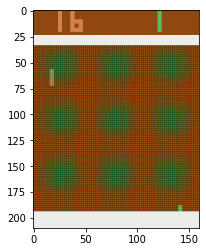

In [26]:
fig = plt.figure()
plt.imshow(observation)
plt.savefig("OriginalImage.png")

In [13]:
fig1 = plt.figure()
observation = observation[34:194]
observation = observation[::3,::3,0] 
observation[observation == 144] = 0 
observation[observation == 109] = 0 
observation[observation != 0] = 1
plt.imshow(observation)
plt.savefig("NewImage.png")

NameError: name 'observation' is not defined

<Figure size 432x288 with 0 Axes>